# **Image Vision**

Just like in NLP tasks, we can embed the information of images to embedding as well. Of course no one will directly say call those as image embeddings. But nevertheless if build properly those acts practically same as normal embeddings we find in NLP tasks.

Such image representations can be used in many usecases like transfer learning, finetuning models that have small datasets or in cases we need to compare images.

In [1]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [8]:
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
img_width, img_height = 224, 224
num_channels = 3
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
                'data/flower_photos/',
                shuffle=True,
                seed=5,
                validation_split=0.2,
                subset='training',
                image_size=(img_height, img_width),
                batch_size=batch_size)
                
valid_ds = tf.keras.utils.image_dataset_from_directory(
                'data/flower_photos/',
                shuffle=True,
                seed=5,
                validation_split=0.2,
                subset='validation',
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Below is an example of using a pretrained model weights as a layer in tensorflow and also called as Transfer Learning.(Essentially like using pretrained embeddings in NLP)

In [10]:
huburl= "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 flower_prob (Dense)         (None, 5)                 165       
                                                                 
Total params: 2,299,141
Trainable params: 41,157
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
92/92 [==============================] - 8s 59ms/step - loss: 0.6079 - accuracy:

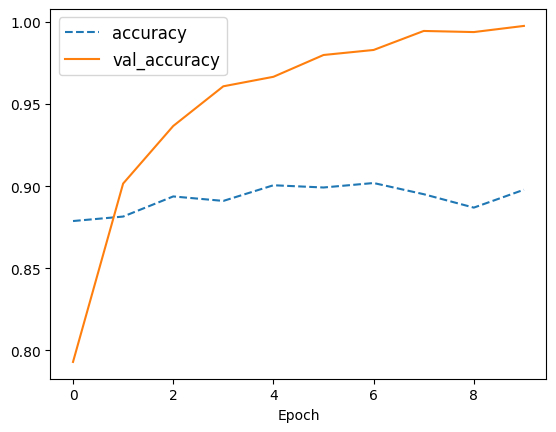

In [13]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.0001)

layers = [
        tf.keras.layers.Rescaling(1./255, offset=0.0,
            input_shape=(img_height, img_width, num_channels),),
        hub.KerasLayer(
            huburl,
            trainable=False,
            name='mobilenet_embedding'),
        tf.keras.layers.Dense(32,
                                kernel_regularizer=regularizer, 
                                activation='relu',
                                name='dense_hidden'),
        tf.keras.layers.Dense(len(train_ds.class_names), 
                                kernel_regularizer=regularizer,
                                activation='softmax',
                                name='flower_prob')
  ]

model = tf.keras.Sequential(layers, name='flower_classification')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=False),
            metrics=['accuracy'])

print(model.summary())

history = model.fit(train_ds, validation_data=valid_ds, epochs=10)
plt.plot(history.history['val_accuracy'], ls='dashed')
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], fontsize=12)

(Note that tensorflow hub models expect input data in certain format, and thats why we have rescaled the image data.)

Also we can fine tune our model further to match our usecase by updating the pretrained weights as well. This basically means making the pretrained weights to trainable parameters. But this comes with several concerns. If our learning rate is too high pretrained weights may get destroyed with large gradient updates and makes the parameters unusable. On the other hand using a too small one will take forever to converge to our use case. 

To circumvent the mentioned issues there are several techniques. First is we can use scheduled learning rates. Which basically means learning rate starts high, but with each iteration it gets decayed exponentially. Also for better results, we can use a warm up learning rate which start at lower level and gradually for a max defined level. From there onwards we can apply decaying behaviour. This is called `Warm up Ramp` and provides better result compared to just learning rate decay.

Other method is `differential learning rates` usage. Basically it means using different learning rates for different layers. We will typically use low learning rates for pretrained layers and normal learning rates for custom layers. To implement this in tensorflow we need to write custom optimizers. But for convienience there's a `python package named AdamW` that can be used to define differential learning rates to tensorflow models. Its usage is seemingly easy, so its worth a shot.

### **Convolutional Networks**

This is the most widely used technique/concept used in modern computer vision models. Basically we are trying to find matrices that could potentially learn the features of our input images like image filters in classical image processing tasks.

Other than the typical convolutional layers, there are many other types of layers is being used in the modern convolutional networks. `Pooling layers` are one of them. Its main purpose is to downsample the input. There are many approaches like max pooling, average pooling etc. What they do is, for the considering kernal window get the maximum value/average value and output that. These are not trainable layers. (Also pooling layers help to make the model location invariant. But in some cases this is not good!)

Early convolutional networks were very shallow(had about 10 layers). But researchers figured that having more layers increased the model ability to identify complex patterns. Also modern architectures prefer to use smaller kernal size opposed to earlier models as that yield lower number of parameters to train while having better non linearity support. (5 * 5 kernal essentially provide the same effect as 3 * 3 kernal). One different type of convolution kernal is `1 * 1 kernals`. It basically means multiplying a stack of channels with single constant. This may seems ridiculus, but in practice this is useful to several channel data to single level with different weightages.

Another important type of layer used in convolutional networks is `Global Average Pooling Layer`. Instead of taking the values across the channels, this would take the average of each channel and return it as the output. This is extremely useful rather than making the convolutional layers flatten. It invloves no learnable parameters and computationally effective as well. But it should be noted that, this remove positional informations that may present in channels.

### Modular Architectures

With the progession of Neural networks, researchers found having different structures of layers provide different results. So they build them as modules and combined such modules as more complex architectures. Below are few of such architectures.

#### **Inception**

Inception module is focused on making the models go deeper. As you can see in the below image, inception modules take the input, process it in multiple paths and aggregate them to provide the output. Also because of the nature of the network construction, we dont need to worry about disadvantages of maxpooling, convolutions etc. Instead network can figure that out itself.

<center><image src="./imgs/1.jpg" width="500px"/></center>

#### **SqueezeNet (Fire Module)**

This module (called fire module) simplified the idea of having multiple paths, compared to Inception modules.

<center><image src="./imgs/2.jpg" width="300px"/></center>


#### **Resnet and Skip Connection**

This is one of the most used type of modules in modern computer vision models. Usage of this skip connections came into play with the problems encountered in deep convolutional models. Namely vanishing/exploding gradient problems. Skip connections help in vanishing gradient by making the original signal passed to the later sections. Check the below diagram. 

<center><image src="./imgs/3.png" width="300px"/></center>

Obviously this has a limitation that addition can only happen only if dimensions did not change during the other operations.

#### **Densenet**

Going ahead with the idea introduced in the Resnet paper, Densenet implement a more complex network by interconnecting all the intermediate layers to layers in front of them. (Check the diagram. It include one block of densenet). 

Also instead of adding the values together like in Resnet, densenet concatenate the previous values as channels to the output(which means will increase the depth dimension of the output). Therefore to avoid channel size getting larger, authors have used 1 * 1 convolutions inside each layer to keep channel dimensions in constant size. 

<center><image src="./imgs/4.png" width="300px"/></center>

This is an interesting architecture due to the fact the input features to a particular block get passed down to later layers. This helps the block to retain information longer IMO.

#### **Xception Architecture (Depth - Separable Convlutions)**

In normal convolutional layers kernals would process all the input channels at once. So basically if input had 8 channels, then the actual kernal matrix would be (asumming 3 * 3) 3 * 3 * 8. So when we define more 16 such kernals it would be 16 such matrices. This may sometimes be inefficient as some filters may recreate same/similar output. 

Instead we can get the convolution channel wise and then stack them again. Then this stack can be manipulated using 1 * 1 kernals to change the dimensions as we need. Check the below diagram.

<center><image src="./imgs/5.png" width="300px"/></center>

This technique reduce the number of trainable parameters used by the network and reduce the computational complexity as well. (in tensorflow there's SeparableConv2D layers, in pytorch we need do this manipulating the dimensions of input)

> In depth separable convolution there's a parameter named 'depth multiplier'. What it does is define how many kernals each channel will get multiplied in the first step of above. Default is 1. Basically this parameter value will increate the number of parameters by defined amount.

The Xception architecture this technique and skip connections has been used as mudules. 

### Neural Architecture Search Designs

So we looked at several architectures and their building blocks previously. But it would we really hard to find proper arrangement of such elements for a new tasks. To simplyfy that there are some architecture. Brief description of them are as follows.


#### **NASNet**

Nasnet authors focused on developing a ML model that would search for the optimal combinations of operations. Since brute force search through all possible operations and hyperparameters is not practical, they suggested a new approach. 

All the architectures we discussed had 2 main types of cells. One would keep the dimensions intact while doing the operation and other one would reduce the size of the channels. The NASNet authors deviced an automated algorithm to create such cells and assembled convolutional architecture by hand with reasonable parameters. Then they trained those networks to see what would work best. This search algorithm could be a random search or more complex Reinforcement learning based one. But apparently it did not make that much of a change. 

<center><image src="./imgs/6.png" width="500px"/></center>

This is an interesting approach to create processing cells(or modules) automatically. Read more details about the usage of this technique as above description is not enough or complete.

Results from this publication indicated very interesting insights about previous model building techniques as well. (having 2 separable convolutions in a row, adding skip connections rather than concatanating etc.)

Read more about this using relevant sources!


#### **MobileNet**

MobileNet is a family of neural networks which include MobileNetV2, MnasNet, EfficientNet etc. Its last models do automated neural architecture search and end up with optimized architectures. Also these model used below new type of building blocks as well.

##### **Depthwise Convolutions**

Practically speaking it seems this name was given to the first part of the septh separable convolution layer. So basically we take the depthwise convolutions but dont do the 1 * 1 convolutions after stacking the outputs. Thats it! 🤷. I dont know why the new name, but it is what it is!

In tensorflow we can use below for Depthwise Convolutions.

        tf.keras.layers.DepthwiseConv2D(kernel_size,
                                        strides=(1, 1),
                                        padding='valid',
                                        depth_multiplier=1)

To do depth separable convolutions in tensorflow we can use below.

        tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3,3))

Above is equivalent to doing below.

        tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3)
        tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1))


##### **Inverted Residual Bottlenecks**

Previous implentations of residual blocks focused on giving early level signals to later sections with the intention of preserving information. But they used the skip connections in a autoencoder like pattern (bottleneck like architecture in the middle - low number of channels). Instead in Inverted Residual Bottlenecks middle of the block have large number of channels (hence inverted name) compared to the input and output.

<center><image src="./imgs/7.png" width="300px"/></center>

The goal of this method was to offer same functionality of Resnet blocks but with reduced weight count and reduced latency during inference. 


The authors worked on above mobilenet architecture later refined their model using automated neural architecture search with inverted residual bottlenecks as the building blocks of their search space. And they introduced the MnasNet and later the EfficientNet models. 


### **Transformer Architecture**

After the introduction of transformer models, computer vision also adapted the transformer architecture to vision problems. Those models are called Vision Transformers.

In image processing world, word can can be considered as a pixel square patch. So like tokenizing in NLP works, we break images in to patches. Then like we do in the NLP transformers, we combine the patch with their respective position value and send the vector through attention layers.

Check this implementation in [Jupyter Notebook](https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03m_transformer_flowers104.ipynb).

But compared to other networks this require large amount of data and therefore authors suggested to train the base model with large amount of data and then finetune to more specific tasks(just like text transformers).

### **Ensemble models**

To achieve highest accuracy values, sometime it is better to use ensemble type models rather than using complicated architectures. The basic idea of using ensemble models is combining several model outputs to get better results (like in random forests). 

One of the key consideration of building ensembles is choosing models different from each other as much as possible. To combine such models we can simply average the class probabilities they predict or can sum up their logits, average it and then do the softmax to get the prediction. 